In [560]:
import json
import base64
import pandas as pd

In [561]:
df = pd.read_json('./logs/test.json', lines=True)
df.head()

,service_name,service_version,api,request_id,task,result,asctime
0,CoralClassifier,20210610144548_CEFA75,predict,9a8b026a-16fd-4b72-ba3e-b8e321b74e8e,"{'data': {}, 'task_id': '9a8b026a-16fd-4b72-ba...","{'data': '""positive""', 'http_status': 200, 'ht...","2021-06-10 14:45:57,495"
1,CoralClassifier,20210610144548_CEFA75,predict,9c3df1bb-656b-4ad2-8fc4-87ba4cff096a,"{'data': {}, 'task_id': '9c3df1bb-656b-4ad2-8f...","{'data': '""positive""', 'http_status': 200, 'ht...","2021-06-10 14:46:02,297"
2,CoralClassifier,20210610144548_CEFA75,predict,8cefa118-184f-4183-ab95-6671e74e6b07,"{'data': {}, 'task_id': '8cefa118-184f-4183-ab...","{'data': '""positive""', 'http_status': 200, 'ht...","2021-06-10 14:46:02,969"
3,CoralClassifier,20210610144548_CEFA75,predict,49121605-4b35-427a-b62e-c769397ee8f2,"{'data': {}, 'task_id': '49121605-4b35-427a-b6...","{'data': '""positive""', 'http_status': 200, 'ht...","2021-06-10 14:46:03,540"
4,CoralClassifier,20210610144548_CEFA75,predict,3c1b6d44-1769-43a0-a0e6-b8a00156eb80,"{'data': {}, 'task_id': '3c1b6d44-1769-43a0-a0...","{'data': '""positive""', 'http_status': 200, 'ht...","2021-06-10 14:46:04,077"


In [562]:
# Add in what we know
clean = df.copy()

tasks = pd.json_normalize(clean.task)
task_headers = tasks.http_headers

results = pd.json_normalize(clean.result)
clean['results'] = results.data.apply(lambda s: s.replace('"', ""))
clean['results_http_status'] = results.http_status

clean = clean.drop(columns=[
    'task',
    'result',
])

clean.head()

,service_name,service_version,api,request_id,asctime,results,results_http_status
0,CoralClassifier,20210610144548_CEFA75,predict,9a8b026a-16fd-4b72-ba3e-b8e321b74e8e,"2021-06-10 14:45:57,495",positive,200
1,CoralClassifier,20210610144548_CEFA75,predict,9c3df1bb-656b-4ad2-8fc4-87ba4cff096a,"2021-06-10 14:46:02,297",positive,200
2,CoralClassifier,20210610144548_CEFA75,predict,8cefa118-184f-4183-ab95-6671e74e6b07,"2021-06-10 14:46:02,969",positive,200
3,CoralClassifier,20210610144548_CEFA75,predict,49121605-4b35-427a-b62e-c769397ee8f2,"2021-06-10 14:46:03,540",positive,200
4,CoralClassifier,20210610144548_CEFA75,predict,3c1b6d44-1769-43a0-a0e6-b8a00156eb80,"2021-06-10 14:46:04,077",positive,200


In [563]:
def decode_axiom_header(row):
    headers = pd.DataFrame(row, columns=['Header', 'Value'])
    coded = headers.loc[headers.Header == 'X-Axiom-Extra', 'Value'].values.item()
    return json.loads(base64.b64decode(coded).decode('utf-8'))

decoded = task_headers.apply(decode_axiom_header)
decoded = pd.json_normalize(decoded)
decoded.head()

,camera_id,filename,timestamp
0,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
1,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
2,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
3,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
4,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z


In [564]:
clean = pd.concat([clean, decoded], axis=1)

clean = clean.rename(columns={
    'asctime': 'request_time',
    'filename': 'image_name',
    'timestamp': 'image_datetime',
})

clean = clean.sort_values('image_datetime', ignore_index=True, ascending=True)

clean.head()

,service_name,service_version,api,request_id,request_time,results,results_http_status,camera_id,image_name,image_datetime
0,CoralClassifier,20210610144548_CEFA75,predict,9a8b026a-16fd-4b72-ba3e-b8e321b74e8e,"2021-06-10 14:45:57,495",positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
1,CoralClassifier,20210610144548_CEFA75,predict,65fb241e-c06c-401b-a27b-8e400d5ad8ab,"2021-06-10 14:46:37,755",positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
2,CoralClassifier,20210610144548_CEFA75,predict,c43eca8f-1ca8-444c-bea1-d75a9ba414dd,"2021-06-10 14:46:37,395",positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
3,CoralClassifier,20210610144548_CEFA75,predict,9a769c52-9521-4413-aa93-eba550a647d6,"2021-06-10 14:46:37,068",positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z
4,CoralClassifier,20210610144548_CEFA75,predict,9b53f268-a492-4f89-8b98-191d2d5d92ea,"2021-06-10 14:46:36,621",positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10T17:57:36Z


In [565]:
# Normalize to dates
clean['image_datetime'] = pd.to_datetime(clean.image_datetime)
clean['request_time'] = pd.to_datetime(clean.request_time)
clean['day'] = clean.image_datetime.dt.normalize().dt.date
clean

,service_name,service_version,api,request_id,request_time,results,results_http_status,camera_id,image_name,image_datetime,day
0,CoralClassifier,20210610144548_CEFA75,predict,9a8b026a-16fd-4b72-ba3e-b8e321b74e8e,2021-06-10 14:45:57.495,positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
1,CoralClassifier,20210610144548_CEFA75,predict,65fb241e-c06c-401b-a27b-8e400d5ad8ab,2021-06-10 14:46:37.755,positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
2,CoralClassifier,20210610144548_CEFA75,predict,c43eca8f-1ca8-444c-bea1-d75a9ba414dd,2021-06-10 14:46:37.395,positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
3,CoralClassifier,20210610144548_CEFA75,predict,9a769c52-9521-4413-aa93-eba550a647d6,2021-06-10 14:46:37.068,positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
4,CoralClassifier,20210610144548_CEFA75,predict,9b53f268-a492-4f89-8b98-191d2d5d92ea,2021-06-10 14:46:36.621,positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
5,CoralClassifier,20210610144548_CEFA75,predict,fe6697b7-cdd4-4281-be4c-2ea2b4065833,2021-06-10 14:46:36.211,positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
6,CoralClassifier,20210610144548_CEFA75,predict,ab22f0e6-9fe5-4265-87ea-1b2d543a4ab4,2021-06-10 14:46:35.525,positive,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
7,CoralClassifier,20210610144548_CEFA75,predict,8ed366d0-9136-4acd-975b-bed9c74afcee,2021-06-10 14:46:26.852,negative,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
8,CoralClassifier,20210610144548_CEFA75,predict,1ec920fe-7af4-47b9-aaaf-95cdac956f69,2021-06-10 14:46:26.475,negative,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10
9,CoralClassifier,20210610144548_CEFA75,predict,5e1ed403-6d59-473d-bfa5-c6f39d3be402,2021-06-10 14:46:26.075,negative,200,FWC Cam 1,fwc-cam1-2021-06-10-175736Z.jpg,2021-06-10 17:57:36+00:00,2021-06-10


In [566]:
# get the unique counts per day
daily_counts = clean.groupby(['day', 'camera_id']).results.value_counts().unstack().fillna(0)
daily_counts

,results,negative,positive
day,camera_id,,
2021-06-10,FWC Cam 1,8,23


<AxesSubplot:title={'center':'Coral Spawning Model Results'}, ylabel='date/cam'>

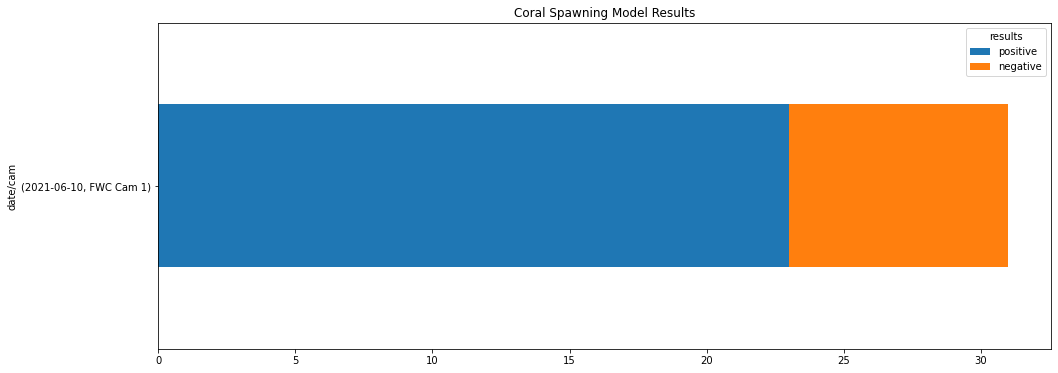

In [567]:
# Sort columns
daily_counts = daily_counts[['positive', 'negative']]
daily_counts.plot.barh(stacked=True, ylabel='count', xlabel='date/cam', rot=0, figsize=(16,6), title='Coral Spawning Model Results')

<AxesSubplot:ylabel='Frequency'>

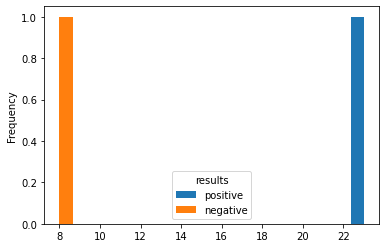

In [568]:
daily_counts.plot.hist(bins=max(daily_counts.negative.max(), daily_counts.positive.max()))

In [537]:
clean.to_csv('coral_spawning_data.csv', index=False)
daily_counts.reset_index().to_csv('coral_spawning_daily_counts.csv', index=False)